# Arboles de decision

En esta clase entrenaremos y exploraremos arboles de decision.

In [1]:
from functools import lru_cache

In [2]:
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

In [3]:
sns.set()

# Carga de datos

Vamos a usar un dataset de [valor de seguros](https://www.kaggle.com/mirichoi0218/insurance), cargandolo desde [github](https://github.com/stedy/Machine-Learning-with-R-datasets). Nuestra variable objetivo será la columna `smoker` que indica si es fumador o no.

In [4]:
@lru_cache()
def get_data():
    """Obtener el dataset.

    Devuelve
    --------
        pd.DataFrame: El dataset descargado desde github.
    """
    df = pd.read_csv(
        'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
    )
    return df


dataset = get_data()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
dataset.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

# Nuestro primer modelo

Ante la duda, tiramos la moneda. Que el Azar™ prediga nuestra variable.

In [7]:
pred = pd.Series(np.random.binomial(1, 0.5, len(dataset))).replace({1: "yes", 0: "no"})
pred

0       yes
1        no
2       yes
3       yes
4        no
       ... 
1333    yes
1334    yes
1335    yes
1336    yes
1337     no
Length: 1338, dtype: object

Ok, tenemos "predicciones". Que hago con esto? Son buenas siquiera?

# Introduccion a metricas
Vamos a profundizar durante la materia sobre este tema. Para saber que tan buena es una prediccion, necesitamos alguna forma de medirlo, tratar de bajarlo a un numero o algo que podamos entender mas facilmente que comparar los valores de verdad y las predicciones.

Por ahora, vamos a quedarnos con la idea de que son funciones $f(valores, predicciones) \to R$, donde a mayor $R$, mejores son nuestras predicciones.

Una metrica bastante intuitiva es la [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score): la cantidad de etiquetas que coinciden _exactamente_ entre nuestras predicciones y las etiquetas reales.

In [8]:
accuracy_score(dataset.smoker, pred)

0.5052316890881914

Lo mejor que puede pasarnos es que valga 1 (acertamos todas!) mientras que lo peor que puede pasarnos es que valga 0 (soy un queso).

Este modelo no parece muy bueno, no?

Veamos que pasa si entendemos un poco mejor los datos.

# Breve análisis exploratorio

In [9]:
report = ProfileReport(
    dataset, title='Dataset de seguros', explorative=True, lazy=False
)

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/pandas_profiling/visualisation/plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


In [10]:
report.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Podemos ver que la variable objetivo está bastante desbalanceada.

# Mejorando el modelo sin partir el espacio

Si tuvieran que hacer un estimador sin ningun `if`, que harian? Que tan bueno seria?

<details>
  <summary>Respuesta</summary>

El estimador más sencillo que podemos armar mirando esto es responder siempre `no`. Y aproximadamente el 80% de las veces tendremos razón!

</details>

In [11]:
pred = ["no"] * len(dataset)
accuracy_score(dataset.smoker, pred)

0.7952167414050823

Sin hacer ninguna particion del espacio ya tenemos un score de 0.80! Podemos mejorarlo encontrando alguna particion del espacio a nuestro favor?

# If: particionando el espacio
Tratemos de entender un poco como es la distribucion de cada variable para los fumadores y no fumadores. A ver si encontramos una particion del espacio que nos ayude!

Solo vale usar **un** if aca.

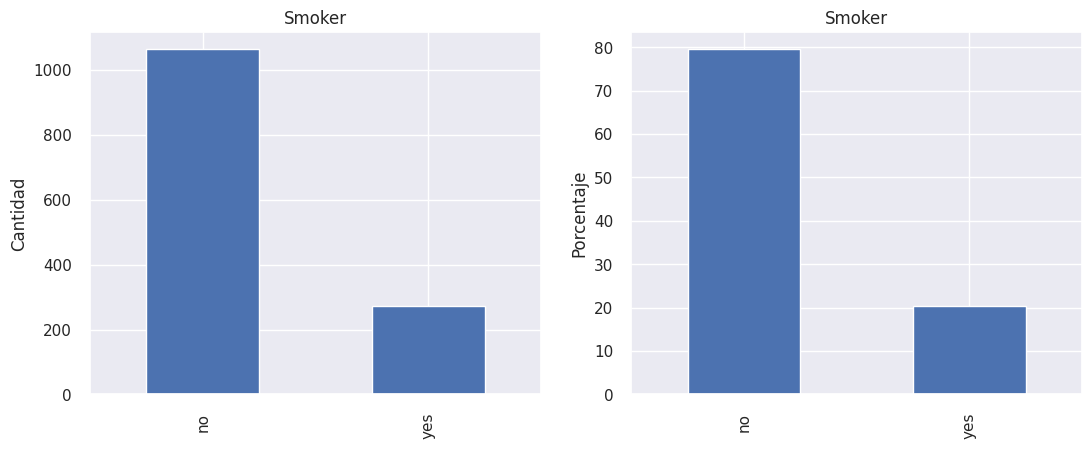

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset.smoker.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Smoker")
axes[0].set_ylabel("Cantidad")

dataset.smoker.value_counts().div(dataset.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1]
)
axes[1].set_title("Smoker")
axes[1].set_ylabel("Porcentaje")

plt.show()

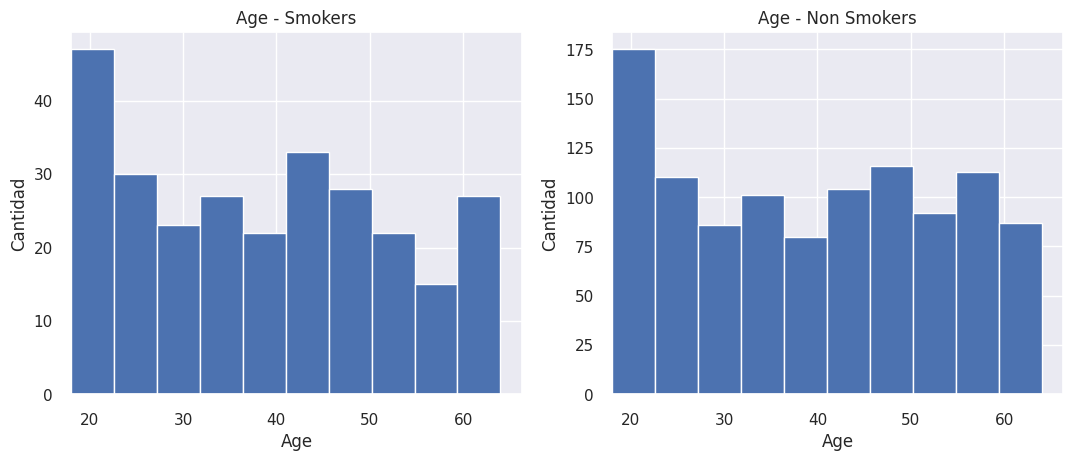

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_smokers = dataset[dataset.smoker == 'yes']
dataset_nonsmokers = dataset[dataset.smoker == 'no']

dataset_smokers.age.plot(kind='hist', ax=axes[0], xlim=dataset.age.min())
axes[0].set_title("Age - Smokers")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Age")

dataset_nonsmokers.age.plot(kind='hist', ax=axes[1], xlim=dataset.age.min())
axes[1].set_title("Age - Non Smokers")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Age")

plt.show()

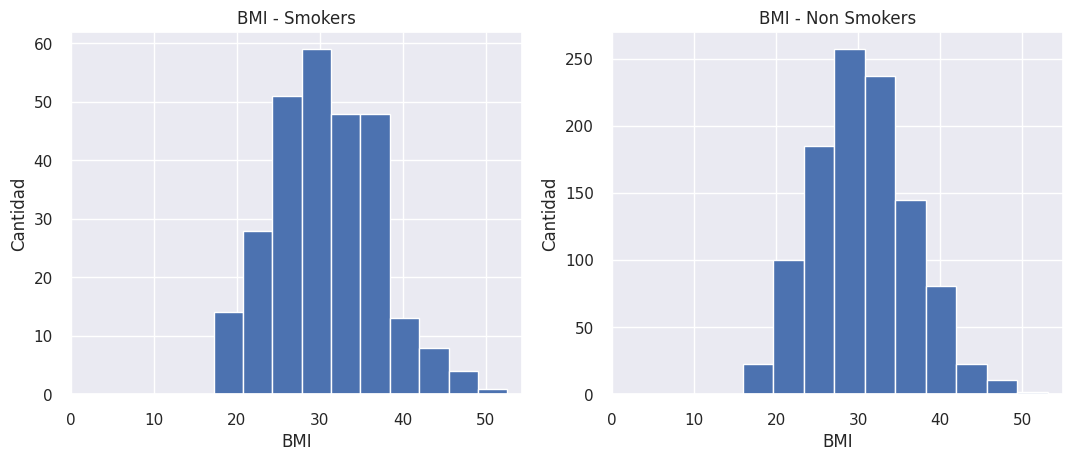

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

dataset_smokers = dataset[dataset.smoker == 'yes']
dataset_nonsmokers = dataset[dataset.smoker == 'no']

dataset_smokers.bmi.plot(kind='hist', ax=axes[0], xlim=0)
axes[0].set_title("BMI - Smokers")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("BMI")

dataset_nonsmokers.bmi.plot(kind='hist', ax=axes[1], xlim=0)
axes[1].set_title("BMI - Non Smokers")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("BMI")

plt.show()

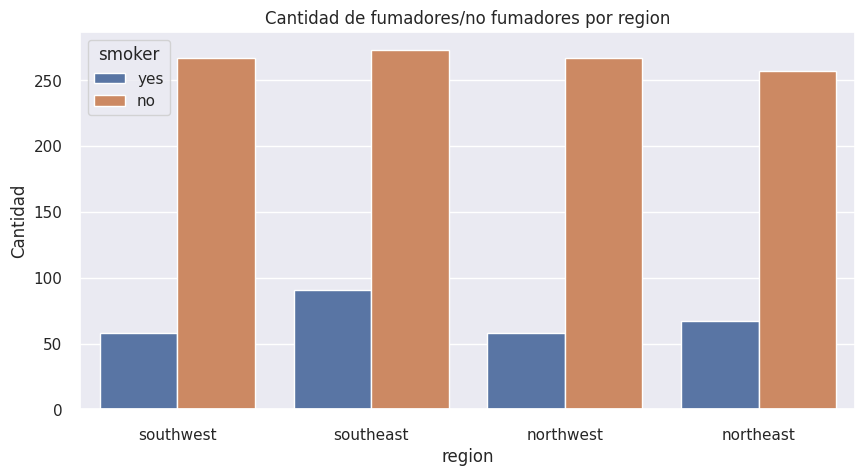

In [15]:
plt.figure(dpi=100, figsize=(10, 5))
sns.countplot(data=dataset, x='region', hue='smoker')
plt.title("Cantidad de fumadores/no fumadores por region")
plt.ylabel("Cantidad")
plt.show()

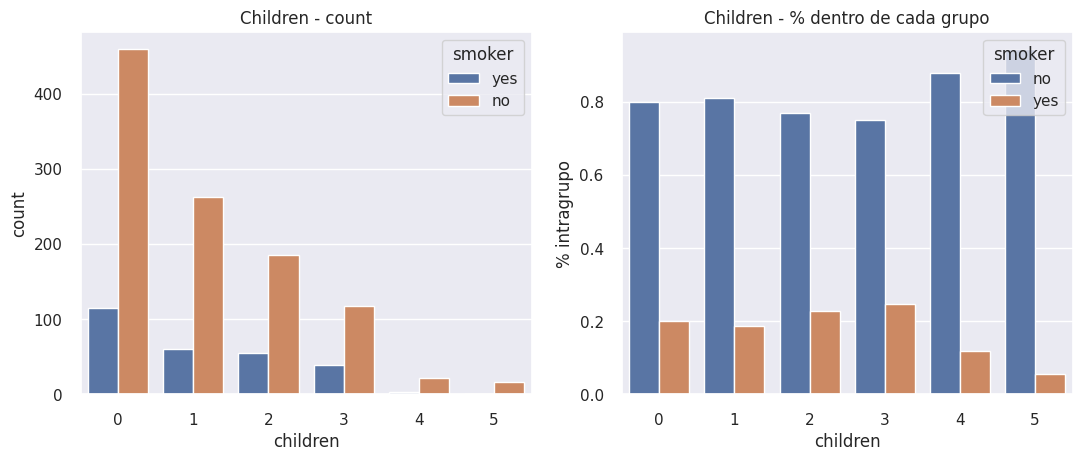

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

sns.countplot(data=dataset, x='children', hue='smoker', ax=axes[0])
axes[0].set_title("Children - count")

sns.barplot(
    data=dataset.groupby("children")
    .smoker.value_counts(normalize=True)
    .rename("smoker_prop")
    .reset_index(),
    x='children',
    y="smoker_prop",
    hue='smoker',
    ax=axes[1],
)
axes[1].set_ylabel("% intragrupo")
axes[1].set_title("Children - % dentro de cada grupo")

plt.show()

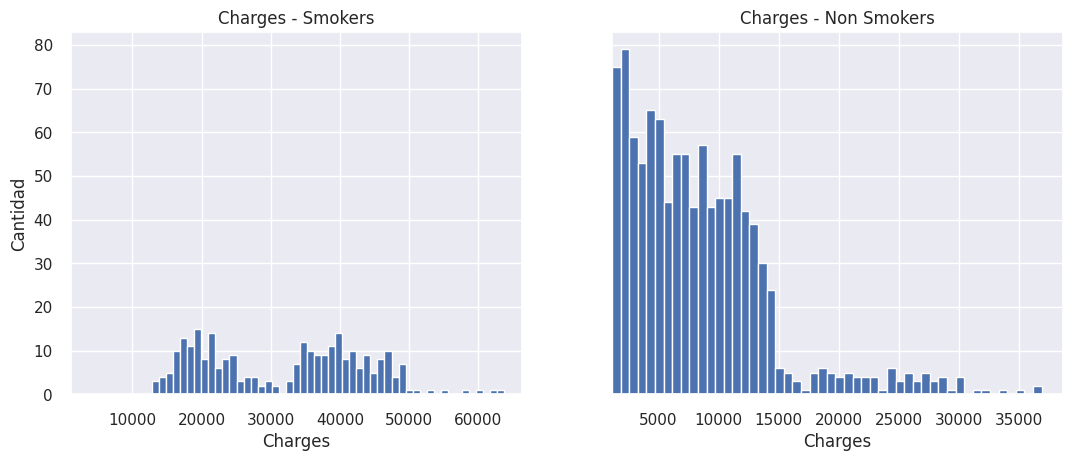

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100, sharey=True)

dataset_smokers = dataset[dataset.smoker == 'yes']
dataset_nonsmokers = dataset[dataset.smoker == 'no']

dataset_smokers.charges.plot(
    kind='hist', ax=axes[0], xlim=dataset.charges.min(), bins=50
)
axes[0].set_title("Charges - Smokers")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Charges")

dataset_nonsmokers.charges.plot(
    kind='hist', ax=axes[1], xlim=dataset.charges.min(), bins=50
)
axes[1].set_title("Charges - Non Smokers")
axes[1].set_xlabel("Charges")
axes[1].set_ylabel("Cantidad")

plt.show()

In [18]:
pred = pd.Series(np.zeros(len(dataset))).replace({1: "yes", 0: "no"})
pred[dataset.charges >= 15_000] = "yes"
accuracy_score(dataset.smoker, pred)

0.9267563527653214

Increible, partimos a ojo el espacio con un if y tenemos mas de 0.92 de score!

Veamos como generaliza la idea, sin tener que decidir _a ojo_ la/s particion/es.

# Manejo de variables

Antes de poder seguir, tenemos que pasar los datos a un formato que le guste a sklearn.

Si revisamos el panel de pandas profiling, podemos ver que las columnas `sex` y `region` son categóricas. Vamos a aplicar [one hot encoding](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) con pandas para estas variables. Por otro lado, usaremos [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de sklearn para crear un mapping de los valores `yes`/`no` de la columna `smoker` a valores numericos.

In [19]:
def feature_engineering(df):
    """Hace las transformaciones de datos necesarias."""
    df = pd.get_dummies(df, drop_first=True, columns=['sex', 'region'])

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df.smoker)

    X = df.drop(columns=['smoker'])
    y = label_encoder.transform(df.smoker)

    return X, y, df, label_encoder


X, y, df, y_encoder = feature_engineering(dataset)
df.head()

age     bmi  children smoker      charges  sex_male  region_northwest  \
0   19  27.900         0    yes  16884.92400         0                 0   
1   18  33.770         1     no   1725.55230         1                 0   
2   28  33.000         3     no   4449.46200         1                 0   
3   33  22.705         0     no  21984.47061         1                 1   
4   32  28.880         0     no   3866.85520         1                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0

# Entrenamiento de nuestro primer arbol de decision

Sklearn [propone](https://scikit-learn.org/stable/developers/develop.html) una interfaz común a todos sus estimadores, pero sin enforzarla. Se espera que tengan un método `.fit` y un método `.predict`. Toda la inicialización de hiperparametros debe estar en el `__init__` de la clase, y deben tener valores por defecto.

Vamos a entrenar un modelo y jugar con la profundidad máxima del árbol. El árbol entrenado, lo visualizaremos utilizando código similar al de la documentación de sklearn encontrado [aquí](https://scikit-learn.org/stable/modules/tree.html#classification).

In [20]:
def get_tree(X, y, max_depth=5, min_samples_leaf=10):
    """Devuelve un árbol entrenado."""
    clf = tree.DecisionTreeClassifier(
        random_state=117, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    clf.fit(X, y)
    return clf


def plot_tree(max_depth, min_samples_leaf):
    """Interfaz interactiva para visualizar un árbol entrenado."""
    df = get_data()
    X, y, df, y_encoder = feature_engineering(df)
    clf = get_tree(X, y, max_depth, min_samples_leaf)

    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=list(y_encoder.classes_),
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))


inter = interactive(
    plot_tree,
    max_depth=IntSlider(min=1, max=15),
    min_samples_leaf=IntSlider(min=1, max=25, value=10),
)
display(inter)

interactive(children=(IntSlider(value=1, description='max_depth', max=15, min=1), IntSlider(value=10, descript…

# Explorando las particiones

[dtreeviz](https://github.com/parrt/dtreeviz) permite explorar un poco mas los árboles. Es un poco más visual que su contraparte de sklearn. Veamos las reglas aprendidas por cada nodo.

In [21]:
X, y, df, y_encoder = feature_engineering(dataset)
clf = get_tree(X, y)

viz = dtreeviz.dtreeviz(
    clf,
    X,
    y,
    target_name='smoker',
    feature_names=list(X.columns),
    class_names=list(y_encoder.classes_),
    scale=1.5,
)

display(viz)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute ['dot', '-Tsvg', '-o', '/tmp/DTreeViz_2276.svg', '/tmp/DTreeViz_2276'], make sure the Graphviz executables are on your systems' PATH

# Por dónde cae una predicción?

Si tomamos una muestra al azar de nuestro dataset y le pedimos al árbol una predicción, como se hace?

In [22]:
def explore_prediction():
    """Interfaz interactiva para ver como se hace una predicción al azar."""
    x_sample = df.sample()
    display(x_sample)

    viz = dtreeviz.dtreeviz(
        clf,
        X,
        y,
        target_name='smoker',
        feature_names=list(X.columns),
        class_names=list(y_encoder.classes_),
        scale=1.0,
        X=x_sample[X.columns].iloc[0].values,
    )

    display(viz)


inter = interactive(explore_prediction, {'manual': True})
display(inter)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Overfitting?

[Momento de reflexion] Si entreno un arbol con todo mi dataset, tiene sentido evaluarlo con ese mismo dataset?

<details>
  <summary>Respuesta</summary>

Basicamente le estamos pidiendo memorizar todo el dataset!
Mi motivacion de entrenar un modelo no es repetir cada dato que le pase (excepto casos como akinator). Esos datos los tengo!
Yo quiero poder predecir nuevos datos, pero si estoy muy sesgado a lo que vi, no puedo generalizar :(

</details>

# Hiperparametros
Los parametros son los valores que el modelo aprende para ajustarse a los datos. Los hiperparametros son instrucciones que rigen el proceso de aprendizaje del modelo.

In [23]:
X, y, _, _ = feature_engineering(dataset)

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=3, min_samples_leaf=10)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=117)

La representacion como string de cada modelo nos da los valores de cada hiperparametro!

Pero que hiperparametros tiene un arbol de decision?

In [24]:
tree.DecisionTreeClassifier?

# Feature importance

Hagamos foco en esta parte de la documentacion:

> feature_importances_ : ndarray of shape (n_features,)
>    The feature importances. The higher, the more important the
>    feature. The importance of a feature is computed as the (normalized)
>    total reduction of the criterion brought by that feature.  It is also
>    known as the Gini importance [4]_.

Lo que nos suele importar en general es el orden relativo de las feature importances o que sean no-cero.

In [25]:
sorted(list(zip(X.columns, clf.feature_importances_)), key=lambda x: -x[1])

[('charges', 0.876491896007543),
 ('bmi', 0.1217598281447605),
 ('age', 0.0017482758476966807),
 ('children', 0.0),
 ('sex_male', 0.0),
 ('region_northwest', 0.0),
 ('region_southeast', 0.0),
 ('region_southwest', 0.0)]

# Sobre arboles, variables categoricas y otras yerbas

Que nos impide teoricamente pasar variables categoricas a un arbol de decision?

[Lectura recomendada](http://web.archive.org/web/20200903175430/https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)

In [26]:
dataset.sex = dataset.sex.astype("category")
dataset.region = dataset.region.astype("category")
dataset.smoker = dataset.smoker.astype("category")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.2 KB


In [27]:
X = dataset.drop(columns="smoker")
y = dataset.smoker

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=5, min_samples_leaf=10)
clf.fit(X, y)

ValueError: could not convert string to float: 'female'

> Que nos impide teoricamente pasar variables categoricas a un arbol de decision?

La implementacion de sklearn :(

## Cuando la cardinalidad explota

Generamos un dataset en base al link anterior. Tenemos una cierta cantidad de variables de ruido, una variable z y una variable categorica c.

Haremos que y valga 1 cuando c sea impar o z sea mayor a un cierto valor pivot.

In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def plot_tree(clf, X, y):
    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=np.unique(y).astype(str),
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))


size = 100_000
noise = 10
categories = 256

cov = np.random.randn(noise, noise)
cov = cov.dot(cov.T)
xs = np.random.multivariate_normal(np.zeros(noise), cov=cov, size=size)
y = np.random.binomial(1, p=sigmoid(0.0125 * np.dot(xs, np.random.randn(noise))))

z_pivot = 10
z = np.random.normal(loc=z_pivot, scale=7, size=2 * size)
z_pos, z_neg = z[z > z_pivot], z[z <= z_pivot]

c = np.random.randint(1, categories, size=size)
c_pos, c_neg = c[np.mod(c, 2) == 1], c[np.mod(c, 2) == 0]

coins = np.random.binomial(1, 0.5, size=size)

z = np.zeros(size)
z[(coins & y) == 1] = np.random.choice(z_pos, size=np.sum((coins & y) == 1))
z[(coins & y) == 0] = np.random.choice(z_neg, size=np.sum((coins & y) == 0))

c = np.zeros(size)
c[((coins == 1) & (y == 1))] = np.random.choice(
    np.hstack([c_pos, c_neg]), size=np.sum((coins == 1) & (y == 1))
)
c[((coins == 0) & (y == 1))] = np.random.choice(
    c_pos, size=np.sum((coins == 0) & (y == 1))
)
c[(y == 0)] = np.random.choice(c_neg, size=np.sum((y == 0)))


df = pd.DataFrame(xs, columns=[f"x{i}" for i in range(noise)]).join(
    pd.DataFrame(y, columns=["y"])
)
df["z"] = z
df["c"] = c

Conociendo el problema, hagamos un par de Predicciones a Ojo Ⓡ.

Primero que c sea impar:

In [29]:
pred = np.mod(df.c.astype(int), 2) == 1
y = df.y
accuracy_score(y, pred)

0.87393

Ahora que sea impar o z sea mayor al pivot.

In [30]:
pred = (np.mod(df.c.astype(int), 2) == 1) | (df.z > z_pivot)
y = df.y
accuracy_score(y, pred)

1.0

Que score obtenemos solo con las variables de ruido?

In [31]:
X = df.drop(columns=["y", "z", "c"])
y = df.y

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=5, min_samples_leaf=10)
clf.fit(X, y)

pred = clf.predict(X)
accuracy_score(y, pred)

0.52482

In [32]:
# plot_tree(clf, X, y)

Y si agregamos z? La del pivot?

In [33]:
X = df.drop(columns=["y", "c"])
y = df.y

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=5, min_samples_leaf=10)
clf.fit(X, y)

pred = clf.predict(X)
accuracy_score(y, pred)

0.75045

In [34]:
# plot_tree(clf, X, y)

Mejoramos!

C es categorica, pero y si la tratamos como int, hasta donde llegamos?

In [35]:
X = df.drop(columns=["y"])
y = df.y

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=5, min_samples_leaf=10)
clf.fit(X, y)

pred = clf.predict(X)
accuracy_score(y, pred)

0.75586

In [36]:
# plot_tree(clf, X, y)

No mejora tanto :(

Idea 💡 Hagamos OHE!

In [37]:
X = df.drop(columns=["y"])
_X = pd.get_dummies(X, "c")
y = df.y

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=5, min_samples_leaf=10)
clf.fit(_X, y)

pred = clf.predict(_X)
accuracy_score(y, pred)

0.75586

In [38]:
# plot_tree(clf, X, y)

Que paso aca?

Acá lo que queremos mostrar es que algunas representaciones o encodings no son siempre las mejores, depende del modelo que estemos usando.

Por ejemplo, usando otro modelo...

In [39]:
X = df.drop(columns=["y"])
X.c = X.c.astype("category")
y = df.y

lgbm_tree = LGBMClassifier(n_estimators=1)
lgbm_tree.fit(X, y)
pred = lgbm_tree.predict(X)
accuracy_score(y, pred)

0.99775